In [1]:
!pip install pyyaml==5.1
import tqdm
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

     |████████████████████████████████| 274 kB 4.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=321d579a7d2cedafbab73f09702029eda069b8cd77b2ff7337a579a69ec73fc9
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 662 kB/s 
     |████████████████████████████████| 145 kB 6.7 MB/s 
     |████████████████████████████████| 130 kB 34.1 MB/s 
     |████████████████████████████████| 74 kB 3.8 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 749 kB 44.8 MB/s 
     |████████████████████████████████

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_280758.pkl: 167MB [00:17, 9.64MB/s]                           


In [6]:
!cp "/content/drive/MyDrive/vortex/dataset-opencv.zip" /content



In [8]:
!unzip -o "/content/dataset-opencv.zip"

Streaming output truncated to the last 5000 lines.
  inflating: dataset-opencv/train/txt/subway_0.txt  
  inflating: dataset-opencv/train/txt/subway_1.txt  
  inflating: dataset-opencv/train/txt/subway_10.txt  
  inflating: dataset-opencv/train/txt/subway_100.txt  
  inflating: dataset-opencv/train/txt/subway_1000.txt  
  inflating: dataset-opencv/train/txt/subway_1001.txt  
  inflating: dataset-opencv/train/txt/subway_1002.txt  
  inflating: dataset-opencv/train/txt/subway_1003.txt  
  inflating: dataset-opencv/train/txt/subway_1004.txt  
  inflating: dataset-opencv/train/txt/subway_1005.txt  
  inflating: dataset-opencv/train/txt/subway_1006.txt  
  inflating: dataset-opencv/train/txt/subway_1007.txt  
  inflating: dataset-opencv/train/txt/subway_1008.txt  
  inflating: dataset-opencv/train/txt/subway_1009.txt  
  inflating: dataset-opencv/train/txt/subway_101.txt  
  inflating: dataset-opencv/train/txt/subway_1010.txt  
  inflating: dataset-opencv/train/txt/subway_1011.txt  
  infla

In [17]:
from posixpath import split
from detectron2.structures import BoxMode

def subway_car(folder):
  subway_list = os.listdir("/content/dataset-opencv/{}".format(folder))
  dataset_dict = []

  #for subway in subway_list:
  images = os.listdir("/content/dataset-opencv/{}/img".format(folder))
  txt = os.listdir("/content/dataset-opencv/{}/txt".format(folder))
  images.sort()
  txt.sort()

  for i in range(len(images)):
    record = {}
    im = cv2.imread("/content/dataset-opencv/{}/img/{}".format(folder, images[i]))
    height, width = im.shape[:2]

    record["file_name"] = "/content/dataset-opencv/{}/img/{}".format(folder, images[i])
    record["image_id"] = i
    record["height"] = height
    record["width"] = width

    with open("/content/dataset-opencv/{}/txt/{}".format(folder, txt[i])) as t:
      lines =t.read().split("\n")
      objs =[]

      for line in lines:
        ground_truth = line.split(' ')
        if len(line):
          obj = {
                "bbox": [int(ground_truth[1]), int(ground_truth[2]), int(ground_truth[3]), int(ground_truth[4])],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": int(ground_truth[0])
            }
          objs.append(obj)
      record["annotations"] = objs
      dataset_dict.append(record)
  return dataset_dict

subway_car("train")
print(len(subway_car("train")))

5000


In [18]:
for d in ["train", "test"]:
    DatasetCatalog.register("subway_" + d, lambda d=d: subway_car(d))
    MetadataCatalog.get("subway_" + d).set(thing_classes=["rectangle"])
shapes_metadata = MetadataCatalog.get("subway_train")

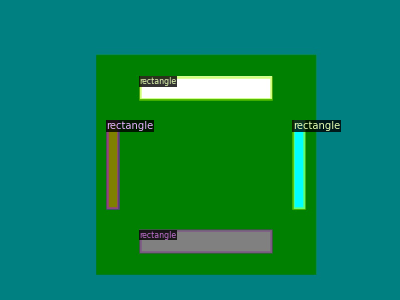

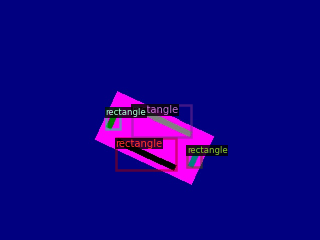

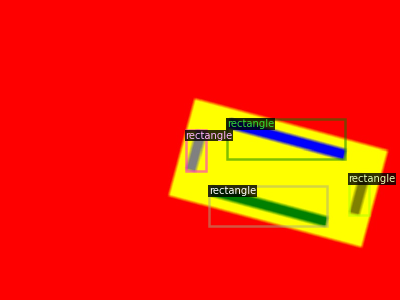

In [19]:
dataset_dicts = subway_car("train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=shapes_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [20]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("subway_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 1000    
cfg.SOLVER.STEPS = []      
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/21 23:38:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[12/21 23:39:18 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/21 23:39:42 d2.utils.events]:  eta: 0:18:24  iter: 19  total_loss: 2.56  loss_cls: 0.799  loss_box_reg: 0.638  loss_rpn_cls: 1.046  loss_rpn_loc: 0.1015  time: 1.1178  data_time: 0.0250  lr: 4.9953e-06  max_mem: 2464M
[12/21 23:40:04 d2.utils.events]:  eta: 0:18:01  iter: 39  total_loss: 1.975  loss_cls: 0.6924  loss_box_reg: 0.6639  loss_rpn_cls: 0.4721  loss_rpn_loc: 0.1039  time: 1.1156  data_time: 0.0112  lr: 9.9902e-06  max_mem: 2464M
[12/21 23:40:27 d2.utils.events]:  eta: 0:17:43  iter: 59  total_loss: 1.739  loss_cls: 0.5791  loss_box_reg: 0.8601  loss_rpn_cls: 0.2827  loss_rpn_loc: 0.06923  time: 1.1214  data_time: 0.0104  lr: 1.4985e-05  max_mem: 2464M
[12/21 23:40:48 d2.utils.events]:  eta: 0:17:15  iter: 79  total_loss: 1.564  loss_cls: 0.5279  loss_box_reg: 0.8667  loss_rpn_cls: 0.08034  loss_rpn_loc: 0.0696  time: 1.1125  data_time: 0.0159  lr: 1.998e-05  max_mem: 2464M
[12/21 23:41:11 d2.utils.events]:  eta: 0:16:58  iter: 99  total_loss: 1.521  loss_cls: 0.4899  los

In [21]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


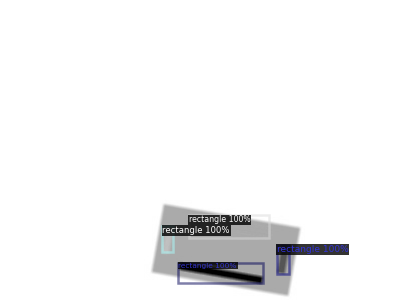

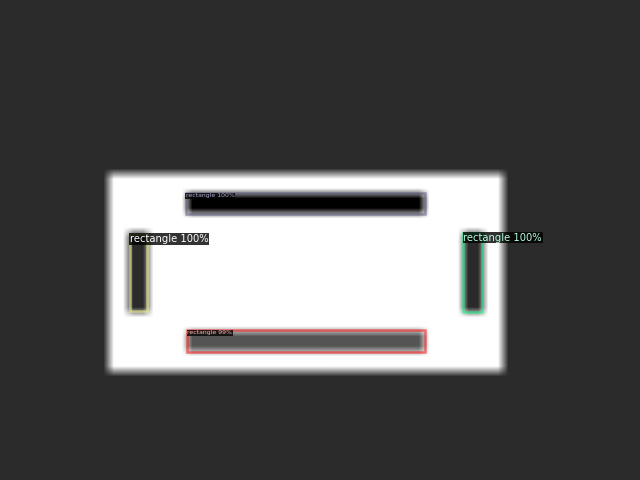

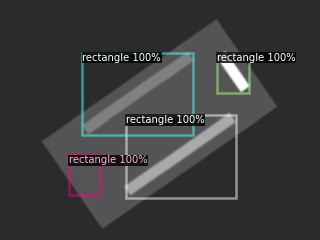

In [22]:
from detectron2.utils.visualizer import ColorMode

data_set_dicts = subway_car("train")
for d in random.sample(data_set_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  
    v = Visualizer(im[:, :, ::-1], metadata=shapes_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [29]:
im = cv2.imread('/content/dataset-opencv/test/img/subway_437.jpg')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


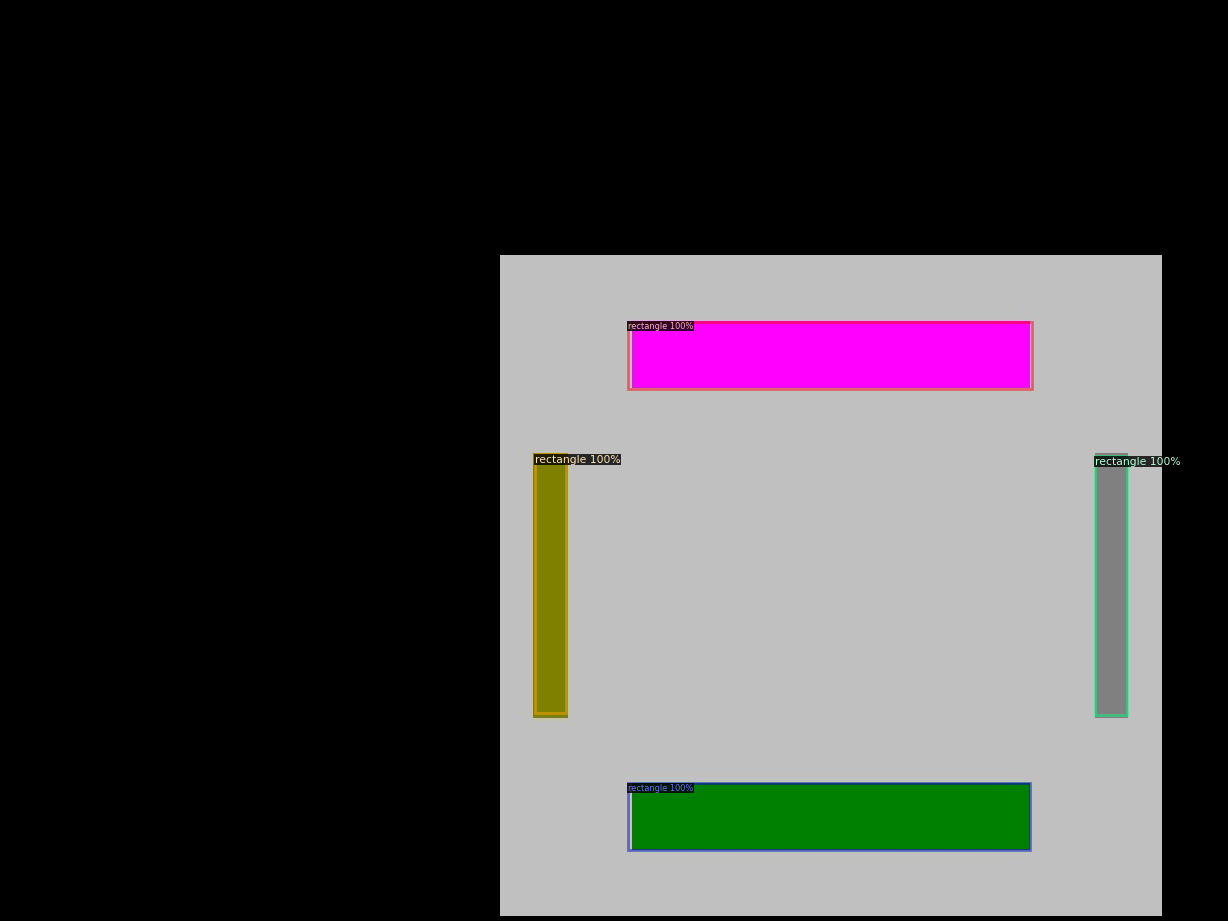

In [27]:
im = cv2.imread('/content/dataset-opencv/test/img/subway_274.jpg')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


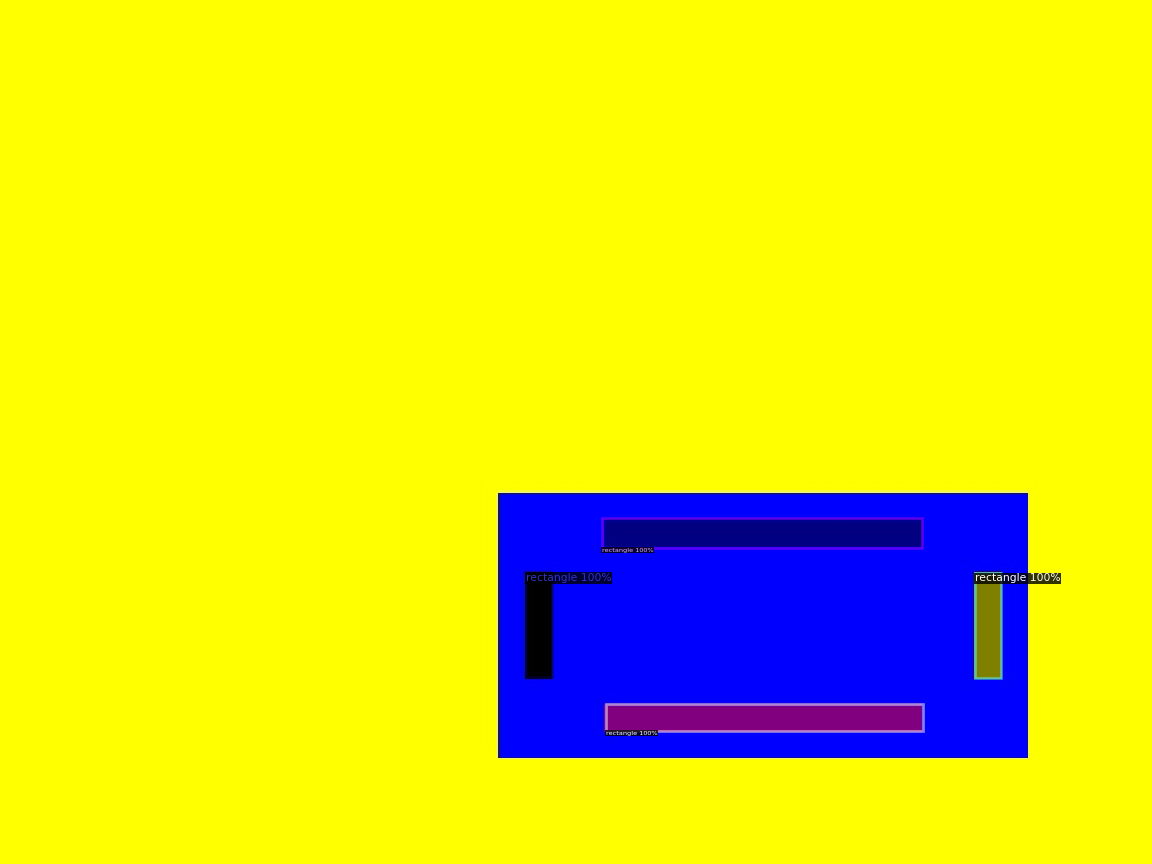

In [28]:
im = cv2.imread('/content/dataset-opencv/test/img/subway_0.jpg')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])